In [30]:
# Importing Modules 
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MaxAbsScaler

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

In [31]:
# Load one of the indices and clean the data
def load_index(path, stdev_window=5, mean_window=5):
    
    df = pd.read_csv(path, parse_dates=True, infer_datetime_format=True, index_col="Date" )

    # Compute stdev
    df['stdev'] = df['Close'].pct_change().rolling(window=stdev_window).std()
    
    # Smooth the data
    for column in df:    
        df[column] = df[column].rolling(window=mean_window).mean()  
    
    df.dropna(inplace=True)
    # print(df.shape)
    print('Data loaded')
    # display(df.head(3))
    
    return df

# index_path = './DATA/INDICES/SP_OHLCV.csv'
# stdev_window = 25
# mean_window = 10
# df_SP = load_index(index_path, stdev_window, mean_window)
# df_SP.stdev.plot(figsize=(16, 10));

In [32]:
# Function for plotting grids with matplotlib
def plot_grid(df, nrows, ncols):
    
    fix, axes = plt.subplots(nrows=nrows, ncols=ncols, dpi=120, figsize=(10,6))
    for i, ax in enumerate(axes.flatten()):
        data = df[df.columns[i]]
        ax.plot(data, linewidth=1)
        
        ax.set_title(df.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines['top'].set_alpha(0)
        ax.tick_params(labelsize=6)
        
    plt.tight_layout();
    
# Plot dataset
# plot_grid(df_SP[['Close', 'stdev', 'Volume']], 3, 1)

In [33]:
def plot_acf_squared(df):

    for column in df:
        if 'return' in column:
            plot_acf(np.power(df[column], 2), title=f'{df[column].name}^2 AutoCorrelation', auto_ylims=True);
            
# plot_acf_squared()

In [34]:
# Check stationarity
def check_stationarity(df, n_diffs=0):
    
    n_diffs = n_diffs
    non_stationary = []
    
    for column in df:
        adfuller_res = adfuller(df[column][1:])
        adf_stat, p_value = adfuller_res[0], adfuller_res[1]
        ci_1, ci_5 = adfuller_res[-2]['1%'], adfuller_res[-2]['5%']
        # print(f'ADF Statistic ({column}): {adf_stat}')
        # print(f'p-value: {p_value}')
        if (adf_stat > ci_1) or (adf_stat > ci_5):
            non_stationary.append(column)
            # print(f'{column} is non stationary.')
        # else:
            # print(f'{column} is stationary!')

    if len(non_stationary) == 0:
        # print(f'All columns are stationary!')
        return df
    
    else:
        df = pd.concat([df[non_stationary].diff(), df.drop(columns=non_stationary)], axis=1).dropna()
        n_diffs += 1
        
        # print(f'Non-stationary columns still exist\nPerforming .diff(): count {n_diffs}')
        return check_stationarity(df, n_diffs), n_diffs
    
# df_SP, n_diffs  = check_stationarity(df_SP)

In [35]:
# Scale the data with MaxAbsScaler
def scale_data(df, n_diffs, n_train, stdev_window, mean_window):

    # Create scaler
    scaler = MaxAbsScaler()
    scaler.fit(df)
    df_scaled = scaler.transform(df)
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns).dropna()

    # Split data
    n_test = len(df) - n_train - n_diffs - stdev_window - mean_window
    df_train = df_scaled.iloc[:n_train]
    df_test = df_scaled.iloc[n_train:n_test+n_train]

    # Create separate test set to preserve index for plotting predictions later
    df_pred_index = df.iloc[n_train:n_test+n_train]

    # print(f'Number of training days: {n_train}')
    print(f'Number of testing days: {n_test}')

    # display(df_train.head(3))
    # display(df_test.head(3))
    
    return df_train, df_test, df_pred_index, n_test
    
# n_train = 2500
# df_train, df_test, df_pred_index, n_test = scale_data(df_SP, n_diffs, n_train, stdev_window)

In [36]:
# Source:
# https://goldinlocks.github.io/Multivariate-time-series-models/
# 
# Create VARMAX model & find the best p,q combination
# NOTE: WARNING!!!, this might take a LONG time to run!!!

def check_p_q(df_train, n_tocheck):
    
    test_results = {}
    
    # How many values to check for p & q
    n_tocheck += 1
    
    for p in range(n_tocheck):
        for q in range(n_tocheck):
            if p == 0 and q == 0:
                continue
                
            print(f'Testing order: p = {p}, q = {q}..')
            convergence_error, stationarity_error = 0, 0
            
            try:
                
                model = VARMAX(
                    df_train,
                    order = (p,q),
                    # trend = 'n',
                    filter_concentrated=True
                )
                model_result = model.fit(maxiter=1000, disp=False)
                    
            except np.linalg.LinAlgError:
                convergence_error += 1
                    
            except ValueError:
                stationarity_error += 1
                    
            # print('\nAIC:', model_result.aic)
            # print('BIC:', model_result.bic)
            # print('HQIC:', model_result.hqic)
            # print('------------------------')

            test_results[(p, q)] = [model_result.aic,
                                    model_result.bic,
                                    convergence_error,
                                    stationarity_error]
    
    print('Done testing.')
    return test_results

# test_results = check_p_q(df_train)


In [37]:
# Source:
# https://goldinlocks.github.io/Multivariate-time-series-models/

def analyze_order(test_results):
    
    # Create test results dataframe
    test_results = pd.DataFrame(test_results).T
    test_results.columns = ['AIC', 'BIC', 'convergence', 'stationarity']
    test_results.index.names = ['p', 'q']
    # test_results.info()
    
    # We want to minimize BIC
    # Visualize the values with a heatmap
    sns.heatmap(test_results.BIC.unstack(), fmt='.2f', annot=True, cmap='Blues_r')
    b, t = plt.ylim() 
    b += 0.5 
    t -= 0.5 
    plt.ylim(b, t) 
    plt.show()
    
    # Get the best model
    # display(test_results.sort_values('BIC').head(3))
    p_best,q_best = test_results.sort_values('BIC').iloc[0].name
    print(f'Best p-value: {p_best}')
    print(f'Best q-value: {q_best}')
    
    return p_best, q_best

# p_best, q_best = analyze_order(test_results)

In [38]:
def create_varmax(df_train, p_best, q_best):

    # Split exogenous and endogenous variables
    # endog = df_train.drop(columns=['Volume'])
    # exog = df_train['Volume']

    # Create VARMAX Model
    model = VARMAX(
        df_train,
        order=(p_best,q_best),
        # trend = 'n',
        # order=(1,2),
        # error_cov_type='diagonal',
        filter_concentrated=True
    )

    # Fit model
    print('Fitting model.. Please wait..')
    model_fit = model.fit(disp=True)
    # model_fit.summary()
    
    return model_fit

# model_fit = create_varmax(df_train, p_best, q_best)

In [39]:
def create_varmax_test(df_train, p_best, q_best):
    
    convergence_error, stationarity_error = 0, 0
    
    try:
    
        model = VARMAX(
            df_train,
            order=(p_best,q_best),
            # trend = 'n',
            # order=(1,2),
            # error_cov_type='diagonal',
            filter_concentrated=True
        )
        
        # Fit model
        print('Fitting model.. Please wait..')
        model_fit = model.fit(disp=True)
            
    except np.linalg.LinAlgError:
        convergence_error += 1
            
    except ValueError:
        stationarity_error += 1
    
    if convergence_error == 0 and stationarity_error == 0:
            return (model_fit, None)
    else:
        errors = (convergence_error, stationarity_error)
        return (None, errors)

# model_fit = create_varmax(df_train, p_best, q_best)

In [40]:
def analyze_predictions(model_fit, df_test, df_pred_index, n_test):

    # Set random seed
    np.random.seed(1)

    # Predicted vs observed volatility
    pred = pd.DataFrame(index=df_pred_index.index)
    pred['prediction'] = model_fit.simulate(n_test).set_index(pred.index, drop=True).stdev
    pred['observed'] = df_test.set_index(pred.index, drop=True).stdev

    # Plot error
    pred['prediction - observed'] = pred['prediction'] - pred['observed']
    pred.plot(figsize=(20,5),title='volatility forecast error',color=['blue','purple','green'],style=['-','-',':'])
    plt.legend(loc=('upper left'));
    
    return pred

# pred = analyze_predictions(model_fit, df_pred_index, n_test, df_test)

In [41]:
def find_error(pred, n_test):
    
    # Compute the error as 'Avg total error per day'
    # This accounts for different test set sizes
    error_total = np.round(np.sum(np.abs(pred['prediction - observed']))/n_test, 10)
    
    return error_total
    
# error_total = find_error(pred)

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
def find_MSE(pred):
    MSE = mean_squared_error(pred['observed', pred['predicted']])
    return MSE

Data loaded
Number of testing days: 425
Fitting model.. Please wait..
Avg Error per Day: 0.054478661
Completed varmax predictions


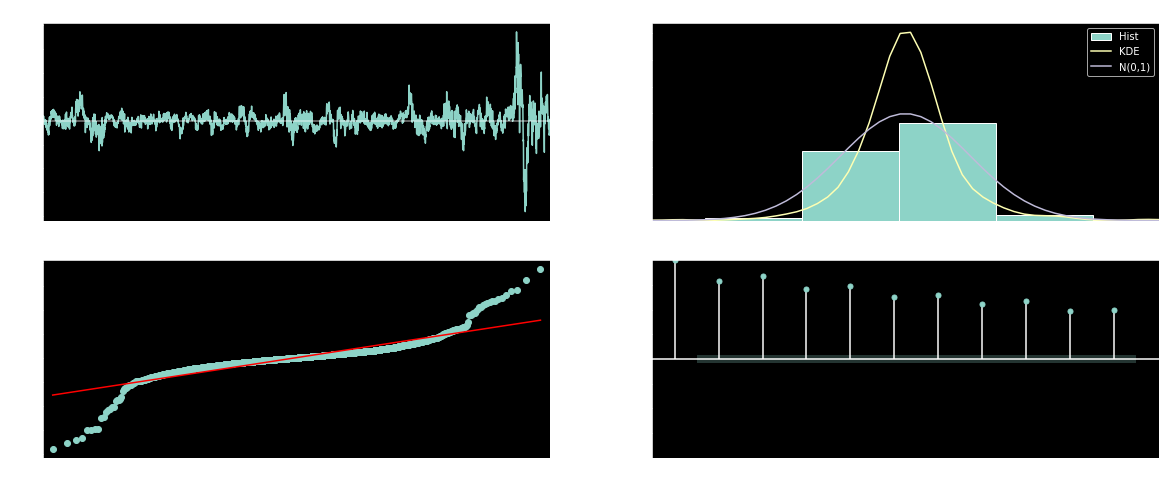

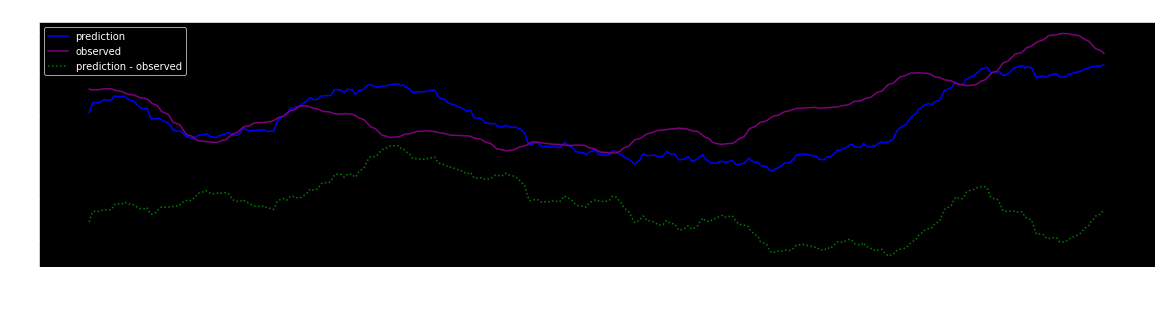

In [44]:
# -------------------------------------------------------------------------------------
# Run everything and return dataframe of predictions
# -------------------------------------------------------------------------------------

def run_varmax_predictions():
    
    path = './DATA/INDICES/SP_OHLCV.csv'
    stdev_window = 35
    mean_window = 15

    df_SP = load_index(path, stdev_window, mean_window)
    # plot_grid(df_SP[['Close', 'stdev', 'Volume']], 3, 1)

    df_SP, n_diffs  = check_stationarity(df_SP)

    n_train = 2500
    df_train, df_test, df_pred_index, n_test = scale_data(df_SP, n_diffs, n_train, stdev_window, mean_window)

    # Setting p, q manually - 1,2 found to give best fit
    p_best, q_best = 1, 2
    model_fit = create_varmax(df_train, p_best, q_best)

    # Plot stdev diagnostics
    model_fit.plot_diagnostics(5,figsize=(20,8), title='');

    pred = analyze_predictions(model_fit, df_test, df_pred_index, n_test)
    error_total = find_error(pred, n_test)
    print(f'Avg Error per Day: {error_total}')
    print('Completed varmax predictions')
    
    return pred
    
pred = run_varmax_predictions()


In [45]:
pred.to_csv('predictions_test')

In [ ]:
# -------------------------------------------------------------------------------------
# Alternate version of the 'Run Everything' function to check for best rolling windows:
# Best windows:
# Mean: 15
# Stdev: 35
# -------------------------------------------------------------------------------------

def run_varmax_predictions_test(stdev_windows, mean_windows):
    
    results = {}
    
    for mean_window in mean_windows:
        for stdev_window in stdev_windows:
            
            print('-----------------------------')
            print(f'Mean window: {mean_window}')
            print(f'Stdev window: {stdev_window}')
            
            path = './DATA/INDICES/SP_OHLCV.csv'

            df_SP = load_index(path, stdev_window, mean_window)
            # plot_grid(df_SP[['Close', 'stdev', 'Volume']], 3, 1)

            df_SP, n_diffs  = check_stationarity(df_SP)

            n_train = 2500
            df_train, df_test, df_pred_index, n_test = scale_data(df_SP, n_diffs, n_train, stdev_window, mean_window)

            # NOTE: Uncomment the lines below to check for best p & q
            # It will take a LONG time if checking more than 2 or 3 values for each
            # It will take an EXTREMELY LONG time if checking for many rolling window too
            # --------------------------------------------------
            # test_results = check_p_q(df_train, 3)
            # p_best, q_best = analyze_order(test_results)
            
            # Setting p, q manually - 1,2 found to give best fit
            p_best, q_best = 1, 2
            model_fit, errors = create_varmax_test(df_train, p_best, q_best)
            
            if errors is not None:    
                conv_error, stationarity_error = errors
                print(f'Convergence error: {conv_error}')
                print(f'Stationarity error: {stationarity_error}')
                results[(stdev_window, mean_window)] = 'Error'
                continue

            # Plot stdev diagnostics
            # model_fit.plot_diagnostics(5,figsize=(20,8));

            pred = analyze_predictions(model_fit, df_test, df_pred_index, n_test)
            error_total = find_error(pred, n_test)
            
            results[(stdev_window, mean_window)] = error_total
            
            print(f'Avg error/day: {error_total}')
            
    return results

# stdev_windows = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
# mean_windows = [5, 10, 15, 20]
# results = run_varmax_predictions_test(stdev_windows, mean_windows)